<div align="center"> 
    <br>
    <br>
    <img src="https://raw.githubusercontent.com/Nikoletos-K/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true" alt="drawing" width="400"/>
    <br>
    <hr>
    <font size="3">Dirty Entity Resolution Tutorial</font>
    <br>
</div>
<hr>

In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. Dirty ER, is the process of dedeplication of one set.

# Instalation

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
!pip install pyjedai

In [ ]:
!pip show pyjedai

Imports

In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

In [3]:
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs

In [4]:
from pyjedai.evaluation import Evaluation

### Data Reading

In [5]:
from pyjedai.datamodel import Data

d1 = pd.read_csv("./../data/cora/cora.csv", sep='|')
gt = pd.read_csv("./../data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']

Data is the connecting module of all steps of the workflow

In [6]:
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

# Workflow with Block Cleaning Methods

In this notebook we created the bellow archtecture:

![workflow1-cora.png](https://github.com/Nikoletos-K/pyJedAI/blob/main/documentation/workflow1-cora.png?raw=true)



### Block Building

In [7]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

In [9]:
blocks = SuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [10]:
Evaluation(data).report(blocks)

#  Evaluation 
---
Scores:
	Precision:      4.28% 
	Recall:        75.77%
	F1-score:       8.10%
Classification report:
	True positives: 13021
	False positives: 291336
	True negatives: 542366
	False negatives: 4163
	Total comparisons: 304357
---


#### OR EmbeddingsNNBlockBuilding

In [ ]:
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

In [12]:
Evaluation(data).report(blocks, emb.method_configuration())

# Embeddings-NN Block Building Evaluation 
---
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: bert
	Similarity-Search: faiss
	Top-K: 30
	Vector size: 768
Runtime: 806.5657 seconds
Scores:
	Precision:     28.98% 
	Recall:        63.34%
	F1-score:      39.77%
Classification report:
	True positives: 10885
	False positives: 26670
	True negatives: 804896
	False negatives: 6299
	Total comparisons: 37555
---


### Block Cleaning

In [12]:
from pyjedai.block_cleaning import BlockFiltering

In [13]:
filtered_blocks = BlockFiltering(
    ratio=0.9
).process(blocks, data)

Block Filtering:   0%|                                                                           | 0/3 [00:00<…

In [14]:
Evaluation(data).report(filtered_blocks)

#  Evaluation 
---
Scores:
	Precision:      5.10% 
	Recall:        73.46%
	F1-score:       9.53%
Classification report:
	True positives: 12623
	False positives: 235069
	True negatives: 598235
	False negatives: 4561
	Total comparisons: 247692
---


### Comparison Cleaning - Meta Blocking

In [15]:
from pyjedai.block_cleaning import BlockPurging

In [16]:
cleaned_blocks = BlockPurging(
    smoothing_factor=0.008
).process(blocks, data)

Block Purging:   0%|          | 0/3420 [00:00<?, ?it/s]

In [17]:
Evaluation(data).report(cleaned_blocks)

#  Evaluation 
---
Scores:
	Precision:      7.67% 
	Recall:         0.59%
	F1-score:       1.09%
Classification report:
	True positives: 101
	False positives: 1215
	True negatives: 819567
	False negatives: 17083
	Total comparisons: 1316
---


In [31]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    # ReciprocalCardinalityWeightPruning,
    ComparisonPropagation
)

In [32]:
candidate_pairs_blocks = WeightedEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [33]:
Evaluation(data).report(candidate_pairs_blocks)

#  Evaluation 
---
Scores:
	Precision:     74.46% 
	Recall:        48.51%
	F1-score:      58.75%
Classification report:
	True positives: 8336
	False positives: 2860
	True negatives: 826157
	False negatives: 8848
	Total comparisons: 11196
---


### Entity Matching

In [22]:
from pyjedai.matching import EntityMatching

In [24]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
)

pairs_graph = EM.predict(filtered_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1684 [00:00<?, ?it/s]

In [34]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.5
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1294 [00:00<?, ?it/s]

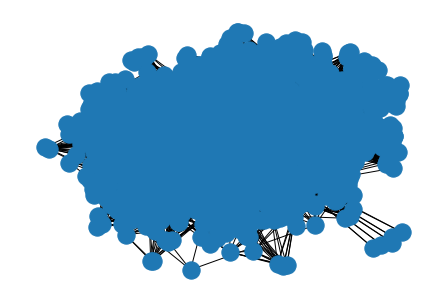

In [25]:
draw(pairs_graph)

In [26]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:      5.44% 
	Recall:         6.30%
	F1-score:       5.84%
Classification report:
	True positives: 1083
	False positives: 18819
	True negatives: 802945
	False negatives: 16101
	Total comparisons: 19902
---


### Entity Clustering

In [27]:
from pyjedai.clustering import ConnectedComponentsClustering

In [28]:
clusters = ConnectedComponentsClustering().process(pairs_graph)

In [29]:
e = Evaluation(data)
e.report(pairs_graph)

#  Evaluation 
---
Scores:
	Precision:      5.44% 
	Recall:         6.30%
	F1-score:       5.84%
Classification report:
	True positives: 1083
	False positives: 18819
	True negatives: 802945
	False negatives: 16101
	Total comparisons: 19902
---


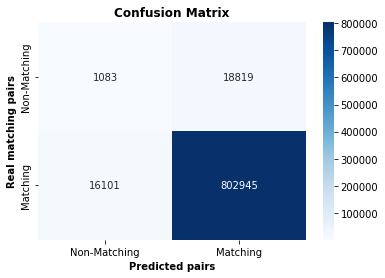

In [30]:
e.confusion_matrix()

# Workflow with Similarity Joins

In this notebook we created the bellow archtecture:

![workflow2-cora.png](https://github.com/Nikoletos-K/pyJedAI/blob/main/documentation/workflow2-cora.png?raw=true)



### Data Reading

Data is the connecting module of all steps of the workflow

In [35]:
from pyjedai.datamodel import Data
d1 = pd.read_csv("./../data/cora/cora.csv", sep='|')
gt = pd.read_csv("./../data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

### Similarity Joins

In [36]:
from pyjedai.joins import SchemaAgnosticΕJoin, TopKSchemaAgnosticJoin

In [37]:
g = SchemaAgnosticΕJoin(
    threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
).fit(data)

Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

In [38]:
e = Evaluation(data)
e.report(g)

#  Evaluation 
---
Scores:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
Classification report:
	True positives: 15987
	False positives: 8311
	True negatives: 828357
	False negatives: 1197
	Total comparisons: 24298
---


In [39]:
g = TopKSchemaAgnosticJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
).fit(data)

Top-K Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

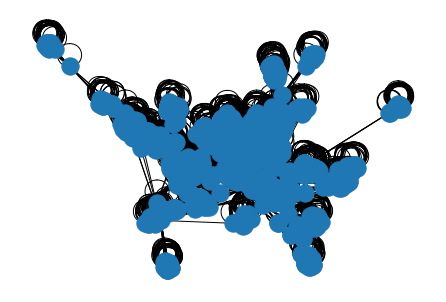

In [40]:
draw(g)

In [41]:
e = Evaluation(data)
e.report(g)

#  Evaluation 
---
Scores:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
Classification report:
	True positives: 10954
	False positives: 7822
	True negatives: 823813
	False negatives: 6230
	Total comparisons: 18776
---


### Entity Clustering

In [42]:
from pyjedai.clustering import ConnectedComponentsClustering

In [43]:
clusters = ConnectedComponentsClustering().process(g)

In [44]:
e = Evaluation(data)
e.report(clusters)

#  Evaluation 
---
Scores:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
Classification report:
	True positives: 17184
	False positives: 820681
	True negatives: 17184
	False negatives: 0
	Total comparisons: 837865
---


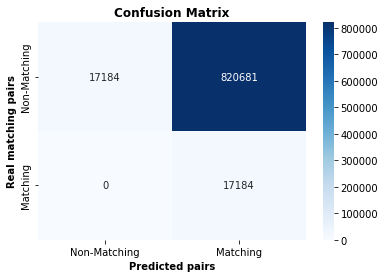

In [45]:
e.confusion_matrix()

<hr>
<div align="right">
K. Nikoletos, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>